In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [2]:
# Set the resolution of the plotted figures
plt.rcParams['figure.dpi'] = 120

# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#F3E8FF'}, style='darkgrid')

In [3]:
# Read dataset
df = pd.read_csv('/kaggle/input/flights/flights.csv')
df.head()

,id,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,...,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,name
0,0,2013,1,1,517.0,515,2.0,830.0,819,11.0,...,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00,United Air Lines Inc.
1,1,2013,1,1,533.0,529,4.0,850.0,830,20.0,...,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00,United Air Lines Inc.
2,2,2013,1,1,542.0,540,2.0,923.0,850,33.0,...,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00,American Airlines Inc.
3,3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,...,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00,JetBlue Airways
4,4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,...,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00,Delta Air Lines Inc.


In [4]:
# Display a concise summary of the dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              336776 non-null  int64  
 1   year            336776 non-null  int64  
 2   month           336776 non-null  int64  
 3   day             336776 non-null  int64  
 4   dep_time        328521 non-null  float64
 5   sched_dep_time  336776 non-null  int64  
 6   dep_delay       328521 non-null  float64
 7   arr_time        328063 non-null  float64
 8   sched_arr_time  336776 non-null  int64  
 9   arr_delay       327346 non-null  float64
 10  carrier         336776 non-null  object 
 11  flight          336776 non-null  int64  
 12  tailnum         334264 non-null  object 
 13  origin          336776 non-null  object 
 14  dest            336776 non-null  object 
 15  air_time        327346 non-null  float64
 16  distance        336776 non-null  int64  
 17  hour      

In [5]:
# Convert 'id' and 'flight' to object data type
df['id'] = df['id'].astype(str)
df['flight'] = df['flight'].astype(str)

In [6]:
# Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,336776.0,2013.000000,0.000000,2013.0,2013.0,2013.0,2013.0,2013.0
month,336776.0,6.548510,3.414457,1.0,4.0,7.0,10.0,12.0
day,336776.0,15.710787,8.768607,1.0,8.0,16.0,23.0,31.0
dep_time,328521.0,1349.109947,488.281791,1.0,907.0,1401.0,1744.0,2400.0
sched_dep_time,336776.0,1344.254840,467.335756,106.0,906.0,1359.0,1729.0,2359.0
dep_delay,328521.0,12.639070,40.210061,-43.0,-5.0,-2.0,11.0,1301.0
arr_time,328063.0,1502.054999,533.264132,1.0,1104.0,1535.0,1940.0,2400.0
sched_arr_time,336776.0,1536.380220,497.457142,1.0,1124.0,1556.0,1945.0,2359.0
arr_delay,327346.0,6.895377,44.633292,-86.0,-17.0,-5.0,14.0,1272.0
air_time,327346.0,150.686460,93.688305,20.0,82.0,129.0,192.0,695.0


In [7]:
# Get the summary statistics for categorical variables
df.describe(include='object')

,id,carrier,flight,tailnum,origin,dest,time_hour,name
count,336776,336776,336776,334264,336776,336776,336776,336776
unique,336776,16,3844,4043,3,105,6936,16
top,0,UA,15,N725MQ,EWR,ORD,2013-09-13 08:00:00,United Air Lines Inc.
freq,1,58665,968,575,120835,17283,94,58665


In [8]:
# Set color for the plots
color = '#8502d1'

# Define function to plot histograms
def plot_hist(column, bins, title, xlabel, fontsize=8, rotation=0):
    plt.figure(figsize=(15,5))
    counts, bins, patches = plt.hist(column, bins=bins, color=color, edgecolor='white')
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Add text annotation for frequencies
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for count, x in zip(counts, bin_centers):
        if count > 0:
            plt.text(x, count, str(int(count)), fontsize=fontsize, ha='center', va='bottom', rotation=rotation)
    plt.show()
    
# Define function to plot bar plots
def plot_bar(column, title, xlabel, fontsize=8, rotation=0):
    plt.figure(figsize=(15,5))
    counts = column.value_counts()
    counts.plot(kind='bar', color=color, edgecolor='white')
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # Add text annotation for frequencies with rotation and larger font size
    for i, v in enumerate(counts):
        plt.text(i, v, str(v), fontsize=fontsize, ha='center', va='bottom', rotation=rotation)
    plt.show()

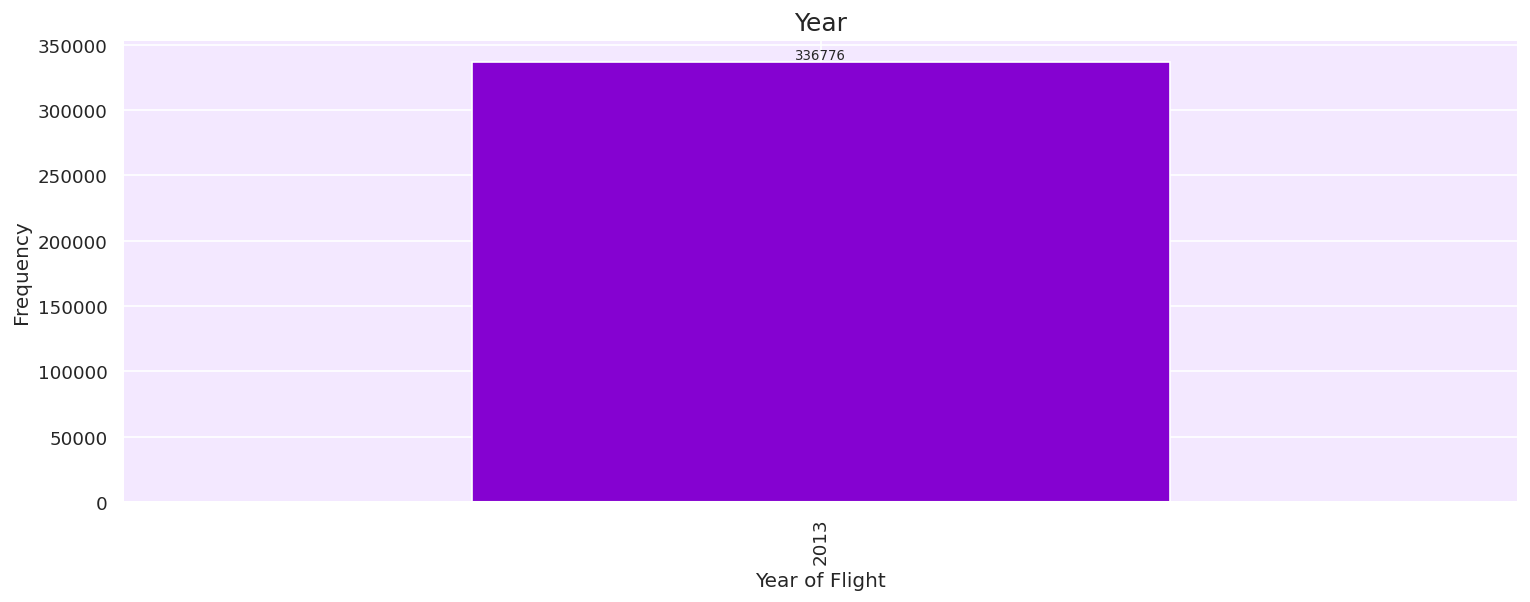

In [9]:
# The year in which the flight took place. The dataset includes flights from the year 2013.
plot_bar(df['year'], 'Year', 'Year of Flight')

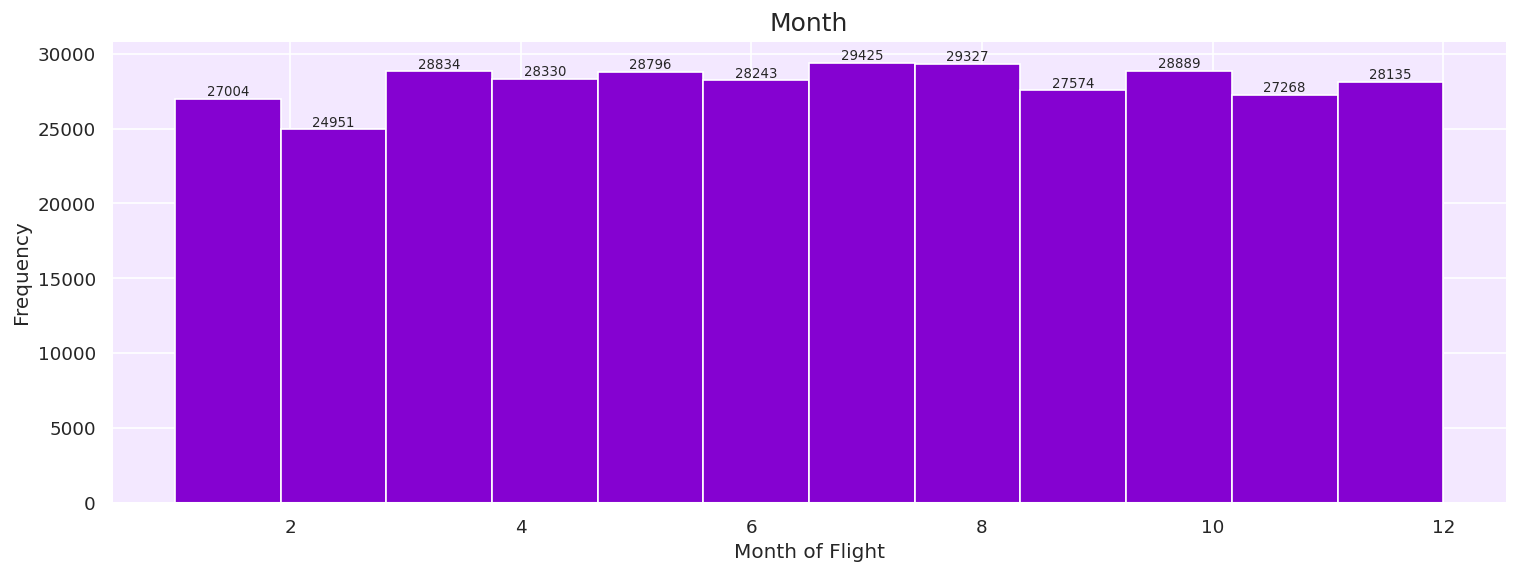

In [10]:
# The month of the year in which the flight occurred, represented by an integer ranging from 1 (January) to 12 (December).
plot_hist(df['month'], bins=12, title='Month', xlabel='Month of Flight')

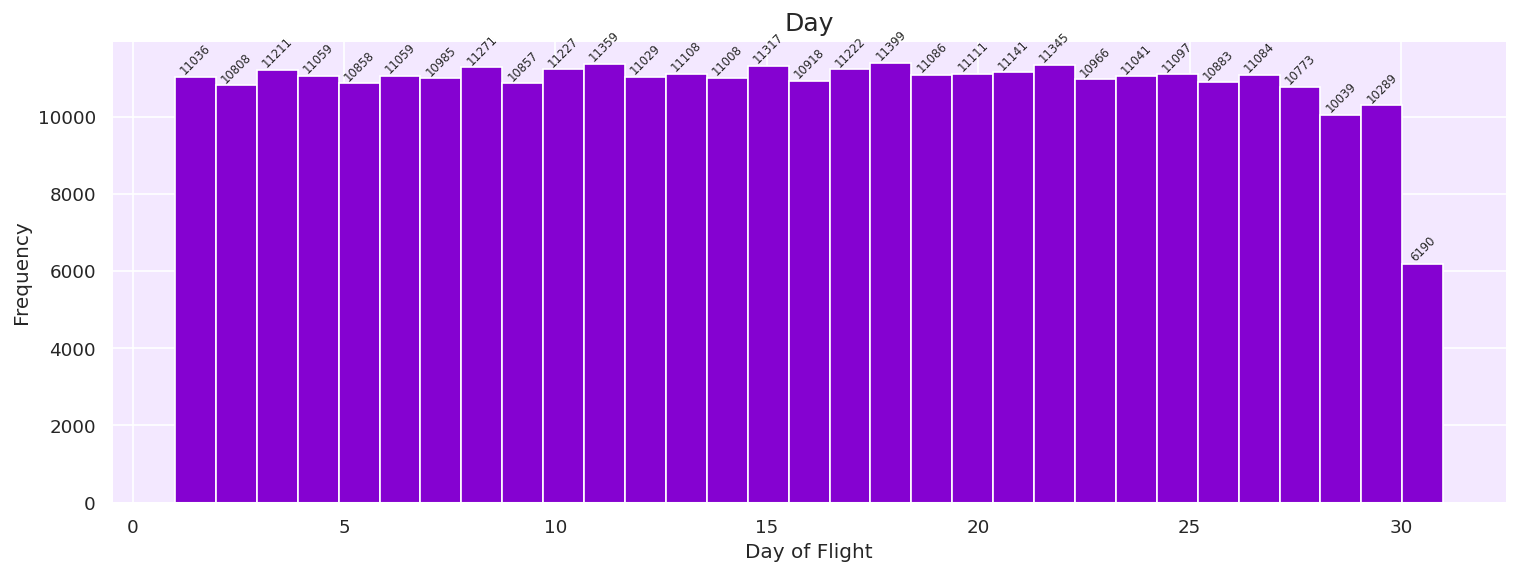

In [11]:
# The day of the month on which the flight took place, represented by an integer from 1 to 31.
plot_hist(df['day'], bins=31, title='Day', xlabel='Day of Flight', fontsize=7, rotation=45)

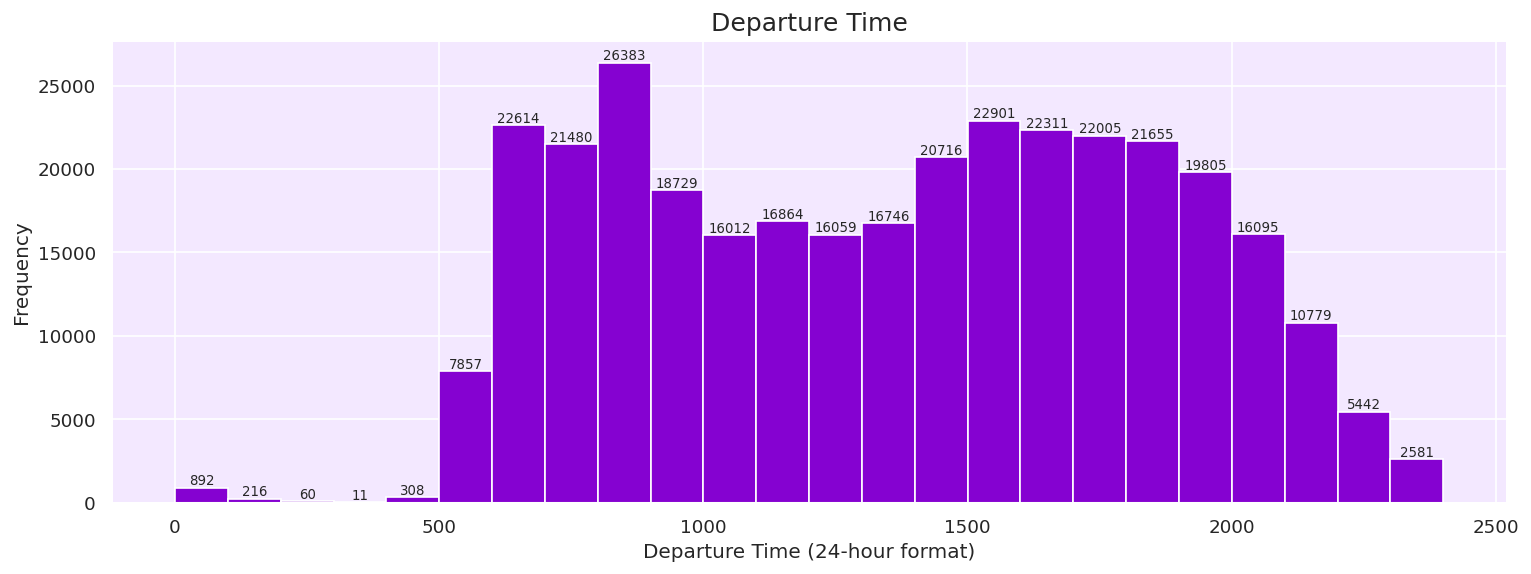

In [12]:
plot_hist(df['dep_time'].dropna(), bins=24, title='Departure Time', xlabel='Departure Time (24-hour format)')

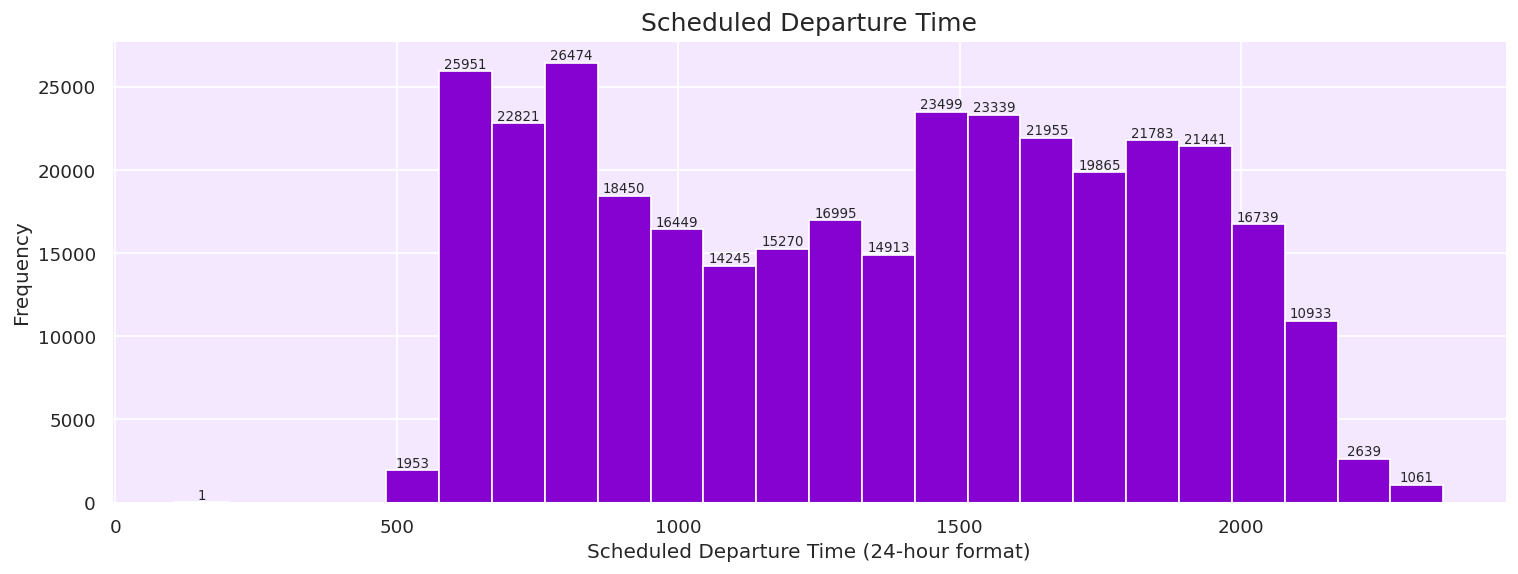

In [13]:
# The locally scheduled departure time of the flight, presented in a 24-hour format (hhmm).
plot_hist(df['sched_dep_time'], bins=24, title='Scheduled Departure Time', xlabel='Scheduled Departure Time (24-hour format)')

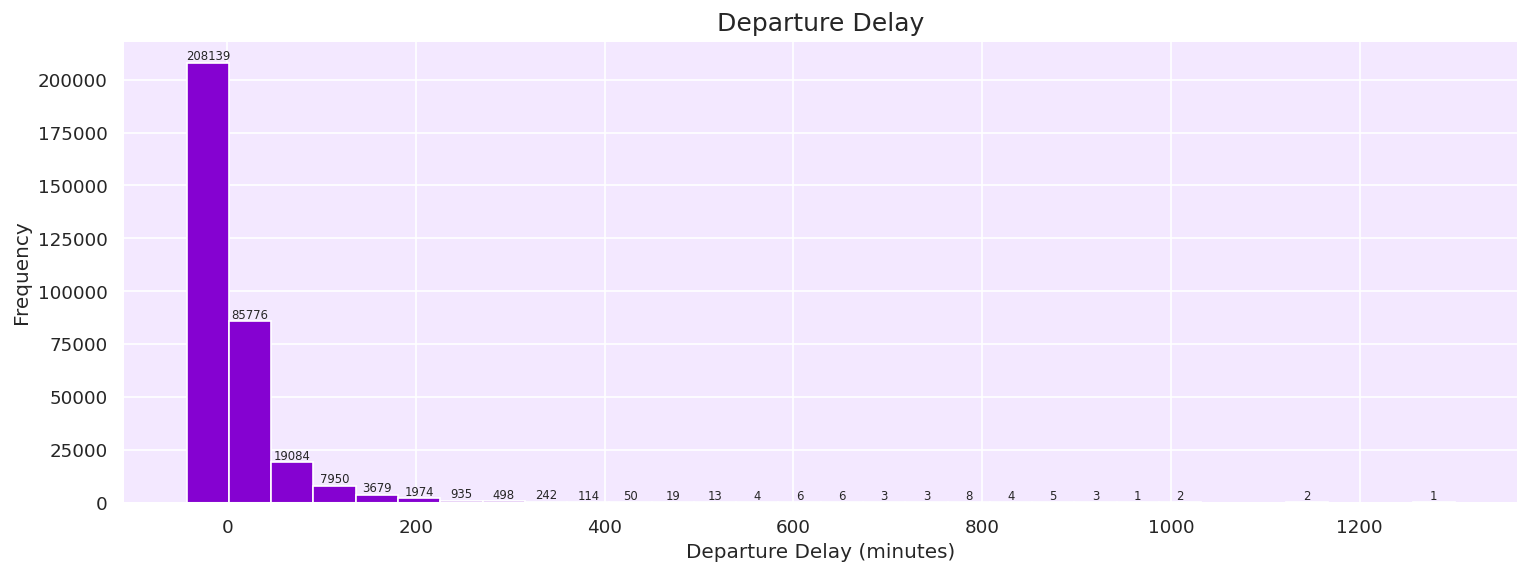

In [14]:
# The delay in flight departure, calculated as the difference (in minutes) between the actual and scheduled departure times. 
# Positive values indicate a delay, while negative values indicate an early departure.
plot_hist(df['dep_delay'].dropna(), bins=30, title='Departure Delay', xlabel='Departure Delay (minutes)', fontsize=7)